<a href="https://colab.research.google.com/github/SaiSatishSuravazula/Deep-Learning/blob/master/Batch_Style_Transfer_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.random.manual_seed(41)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CircularConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)  # 1x1 conv

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Apply Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Applies Xavier initialization to convolutional layers."""
        for layer in [self.conv1, self.conv2, self.conv3]:
            nn.init.xavier_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

# **MultiScale Generator**
class MultiScaleGenerator(nn.Module):
    def __init__(self, num_scales=5, image_size=256):
        super().__init__()
        self.num_scales = num_scales
        self.image_size = image_size

        self.initial_convs = nn.ModuleList([CircularConvBlock(6, 8) for _ in range(num_scales)])
        self.initial_bns = nn.ModuleList([nn.BatchNorm2d(8) for _ in range(num_scales)])

        self.conv_blocks = nn.ModuleList()
        self.conv_bns = nn.ModuleList()
        out_channels = 16
        for i in range(1, num_scales):
            self.conv_blocks.append(CircularConvBlock(out_channels, out_channels))
            self.conv_bns.append(nn.BatchNorm2d(out_channels - 8))
            out_channels += 8

        self.final_conv = nn.Conv2d(40, 3, kernel_size=1)
        self.final_bn = nn.BatchNorm2d(3)

    def forward(self, content_image):
        batch_size = content_image.size(0)
        current = None

        for i in range(self.num_scales):
            scale = self.image_size // (2 ** (self.num_scales - 1 - i))
            z_i = torch.rand(batch_size, 3, scale, scale, device=content_image.device)

            content_resized = F.interpolate(content_image, size=(scale, scale), mode='bilinear', align_corners=False)
            z_i = torch.cat([z_i, content_resized], dim=1)
            z_i = self.initial_convs[i](z_i)
            z_i = self.initial_bns[i](z_i)

            if current is None:
                current = z_i
            else:
                current = F.interpolate(current, scale_factor=2, mode='nearest')
                current = self.conv_bns[i - 1](current)
                current = torch.cat([current, z_i], dim=1)
                current = self.conv_blocks[i - 1](current)

        output = F.relu(self.final_bn(self.final_conv(current)))
        return output / (output.max() + 1e-8)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Style Image Shape: torch.Size([1, 3, 256, 256])


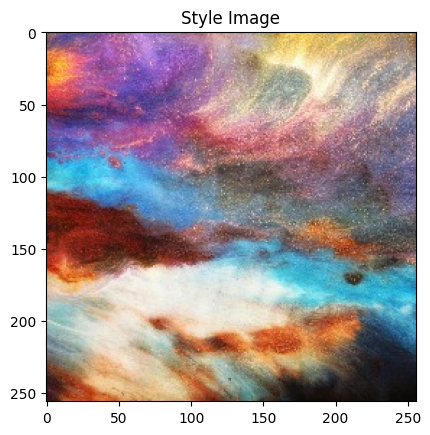

In [ ]:


# Function to load and transform an image
def load_texture(img_path, size=256):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to display an image
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)  # Remove batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

# # Define paths to your images in Google Drive
# content_path = "/content/drive/MyDrive/dancing.jpg"  # Change filename if needed
style_path = "/content/drive/MyDrive/style_image.jpg"      # Change filename if needed

# # Load images
# content_image = load_texture(content_path)
style_image = load_texture(style_path)

# # Print shapes
# print("Content Image Shape:", content_image.shape)  # Expected: (1, 3, 256, 256)
print("Style Image Shape:", style_image.shape)      # Expected: (1, 3, 256, 256)

# # Display images
# imshow(content_image, title="Content Image")
imshow(style_image, title="Style Image")


In [ ]:
# load pretrained VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad_(False)
print(vgg[0].weight.requires_grad)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 96.7MB/s]


False


In [ ]:
# define required layers
content_layer = "conv4_2"
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

layer_map = {
    0: "conv1_1", 5: "conv2_1", 10: "conv3_1",
    19: "conv4_1", 21: "conv4_2", 28: "conv5_1"
}

In [ ]:
# define feature extractor class for extracting content and style features
class VGGFeatureExtractor(nn.Module):
    def __init__(self, model, content_layer, style_layers):
        super(VGGFeatureExtractor, self).__init__()
        self.model = model
        self.content_layer = content_layer
        self.style_layers = style_layers
        self.features = {}

        # Register hooks
        for idx, module in self.model._modules.items():
            idx = int(idx)
            if idx in layer_map:
                module.register_forward_hook(self.hook_fn(layer_map[idx]))

    def hook_fn(self, layer_name):
      def hook(module, input, output):
        self.features[layer_name] = output
      return hook

    def forward(self, x):
        self.features = {}
        self.model(x)
        return self.features

In [ ]:
# Instantiate feature extractor
feature_extractor = VGGFeatureExtractor(vgg, content_layer, style_layers)

In [ ]:
# # Extract content features from content image and style features from style image and store it
# with torch.no_grad():
#   # content_features = feature_extractor(content_image)
#   style_features = feature_extractor(style_image)

In [ ]:
def gram_matrix(feature_map):
    B, C, H, W = feature_map.shape  # Batch, Channels, Height, Width
    feature_map = feature_map.view(B, C, H * W)  # Preserve batch dimension
    gram = torch.bmm(feature_map, feature_map.transpose(1, 2))  # Batch matrix multiplication
    return gram / (C * H * W)  # Normalize

In [ ]:
def compute_total_loss(generated_features, content_features, style_features,
                       content_weight=1, style_weight=1e6):
    """
    Computes the total loss for texture synthesis:
    - Content Loss: Preserves the original structure
    - Style Loss: Enforces texture similarity using Gram matrices
    """

    # Content Loss (MSE between generated and original content feature)
    content_loss = F.mse_loss(
        generated_features[content_layer], content_features[content_layer]
    )

    # Style Loss (Gram matrix difference)
    style_loss = 0
    for layer in style_layers:
        gram_generated = gram_matrix(generated_features[layer])
        gram_style = gram_matrix(style_features[layer])
        style_loss += F.mse_loss(gram_generated, gram_style)

    # Weighted total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss


In [ ]:
# Create model instance
generator = MultiScaleGenerator(num_scales=5, image_size=256).to(device)

In [ ]:



from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Custom Dataset to Load Images Directly from a Folder
class ContentDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # No label, just return image tensor

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load content images correctly
content_folder = "/content/drive/MyDrive/ContentImages"  # Ensure this path exists
content_dataset = ContentDataset(content_folder, transform)
content_loader = DataLoader(content_dataset, batch_size=10, shuffle=True, drop_last=True)


# Xavier Initialization Function
def xavier_init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator model (Assume it's already defined)
generator.train()  # Ensure it's in training mode

# Apply Xavier initialization
generator.apply(xavier_init_weights)

# Hyperparameters
num_iterations = 2000
lr = 0.1
lr_decay_factor = 0.7
lr_decay_schedule = [1000] + list(range(1200, num_iterations, 200))

# Weights for loss trade-off
content_weight = 1
style_weight = 1e6

# Optimizer & Scheduler
optimizer = optim.Adam(generator.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_decay_schedule, gamma=lr_decay_factor)

# Extract style features once (Fixed, No Gradients)
with torch.no_grad():
    style_features = feature_extractor(style_image)

# **Training Loop**
content_iter = iter(content_loader)  # Create an iterator for infinite looping

for iteration in range(num_iterations):
    optimizer.zero_grad()  # Reset gradients

    # Get next batch of content images (Loop back when exhausted)
    try:
        content_batch = next(content_iter)
    except StopIteration:
        content_iter = iter(content_loader)  # Restart dataset
        content_batch = next(content_iter)

    content_batch = content_batch.to(device)  # Move to GPU if available

    # Generate images
    generated_images = generator(content_batch)
    generated_features = feature_extractor(generated_images)

    # Compute total loss
    total_loss = compute_total_loss(generated_features, feature_extractor(content_batch), style_features,
                                    content_weight=content_weight, style_weight=style_weight)

    total_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    scheduler.step()  # Adjust learning rate

    # Print loss every 100 iterations
    if iteration % 100 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Iteration {iteration}: Total Loss = {total_loss.item()}, LR = {current_lr}")

# **Final Evaluation Mode**
generator.eval()

Iteration 0: Total Loss = 7.953948020935059, LR = 0.1
Iteration 100: Total Loss = 3.8276290893554688, LR = 0.1
Iteration 200: Total Loss = 3.400350570678711, LR = 0.1
Iteration 300: Total Loss = 3.2178733348846436, LR = 0.1
Iteration 400: Total Loss = 2.967782735824585, LR = 0.1
Iteration 500: Total Loss = 3.2920784950256348, LR = 0.1
Iteration 600: Total Loss = 2.8410184383392334, LR = 0.1
Iteration 700: Total Loss = 2.9881763458251953, LR = 0.1
Iteration 800: Total Loss = 2.7609286308288574, LR = 0.1
Iteration 900: Total Loss = 2.92484450340271, LR = 0.1
Iteration 1000: Total Loss = 2.665283441543579, LR = 0.06999999999999999
Iteration 1100: Total Loss = 2.56803822517395, LR = 0.06999999999999999
Iteration 1200: Total Loss = 2.6130335330963135, LR = 0.048999999999999995
Iteration 1300: Total Loss = 2.611948251724243, LR = 0.048999999999999995
Iteration 1400: Total Loss = 2.7914626598358154, LR = 0.0343
Iteration 1500: Total Loss = 2.828557014465332, LR = 0.0343
Iteration 1600: Total 

MultiScaleGenerator(
  (initial_convs): ModuleList(
    (0-4): 5 x CircularConvBlock(
      (conv1): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (conv3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (initial_bns): ModuleList(
    (0-4): 5 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_blocks): ModuleList(
    (0): CircularConvBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=

Content Image Shape: torch.Size([1, 3, 256, 256])
Style Image Shape: torch.Size([1, 3, 256, 256])


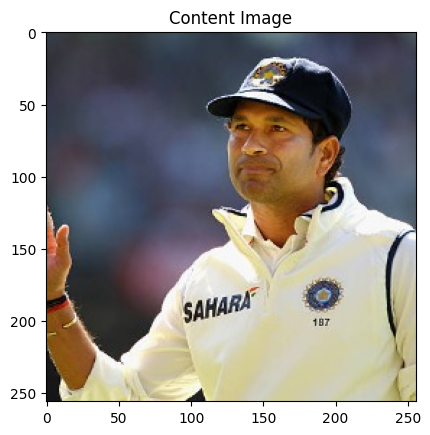

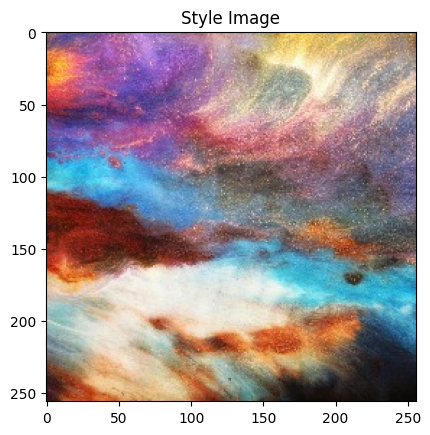

In [ ]:
# Define paths to your images in Google Drive
content_path = "/content/drive/MyDrive/content_image.jpg"  # Change filename if needed
style_path = "/content/drive/MyDrive/style_image.jpg"      # Change filename if needed

# Load images
content_image = load_texture(content_path)
style_image = load_texture(style_path)

# Print shapes
print("Content Image Shape:", content_image.shape)  # Expected: (1, 3, 256, 256)
print("Style Image Shape:", style_image.shape)      # Expected: (1, 3, 256, 256)

# Display images
imshow(content_image, title="Content Image")
imshow(style_image, title="Style Image")


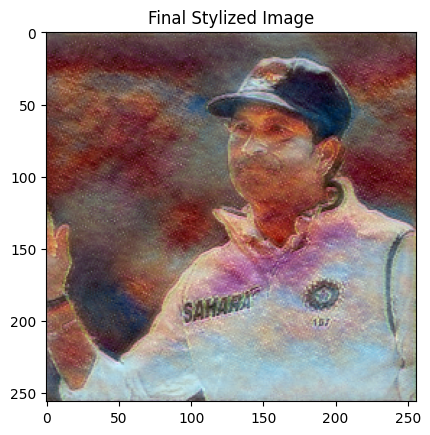

In [ ]:
# # Switch generator to evaluation mode before inference
# generator.eval()

# Generate final stylized image without gradients
with torch.no_grad():
    stylized_image = generator(content_image)

# Display the final output
imshow(stylized_image, title="Final Stylized Image")

Content Image Shape: torch.Size([1, 3, 256, 256])
Style Image Shape: torch.Size([1, 3, 256, 256])


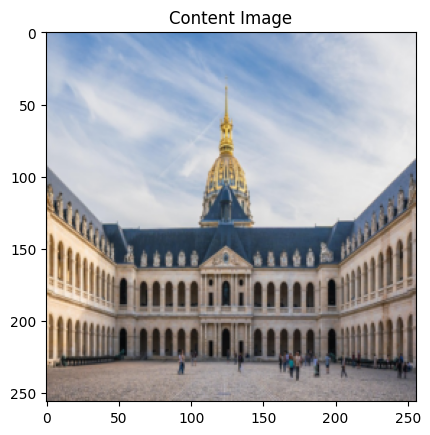

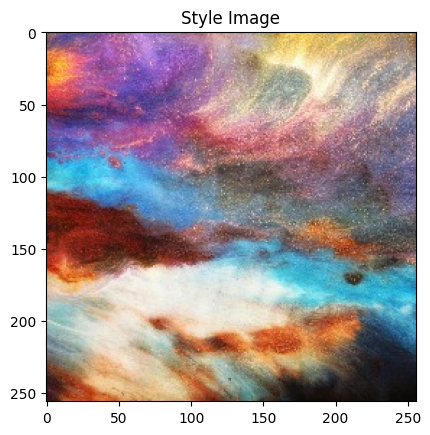

In [ ]:
# Define paths to your images in Google Drive
content_path = "/content/drive/MyDrive/invalidendom-8596490_960_720.jpg"  # Change filename if needed
style_path = "/content/drive/MyDrive/style_image.jpg"      # Change filename if needed

# Load images
content_image = load_texture(content_path)
style_image = load_texture(style_path)

# Print shapes
print("Content Image Shape:", content_image.shape)  # Expected: (1, 3, 256, 256)
print("Style Image Shape:", style_image.shape)      # Expected: (1, 3, 256, 256)

# Display images
imshow(content_image, title="Content Image")
imshow(style_image, title="Style Image")

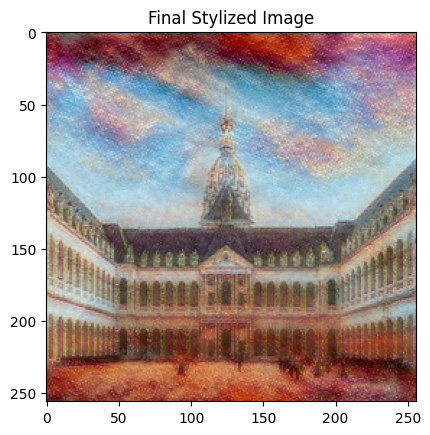

In [ ]:
# Generate final stylized image without gradients
with torch.no_grad():
    stylized_image = generator(content_image)

# Display the final output
imshow(stylized_image, title="Final Stylized Image")